In [1]:
import numpy as np
import glob
import matplotlib.pyplot as plt

# read csv files from results folder
path = np.array([], dtype=str)
score = np.array([], dtype=float)
time = np.array([], dtype=float)
for file in glob.glob("../results/attempt3/*.csv"):
    print(file)
    # read csv file as strings
    data = np.genfromtxt(file, delimiter=',', skip_header=1, dtype=str)
    # the first column is the path
    path = np.append(path, data[:,0])
    # get the second column
    score = np.append(score, data[:,1].astype(float))   
    # get the third column
    time = np.append(time, data[:,2].astype(float))
print(score)
# coloring scheme
maroon = (111/255, 0, 36/255)
orange = (207/255, 69/255, 32/255)

../results/attempt3/results_0531.csv
../results/attempt3/results_0601.csv
../results/attempt3/results_0313-1.csv
../results/attempt3/results_0313-2.csv
[0.67808238 0.65154083 0.14092252 ... 0.49187911 0.98559179 0.34728532]


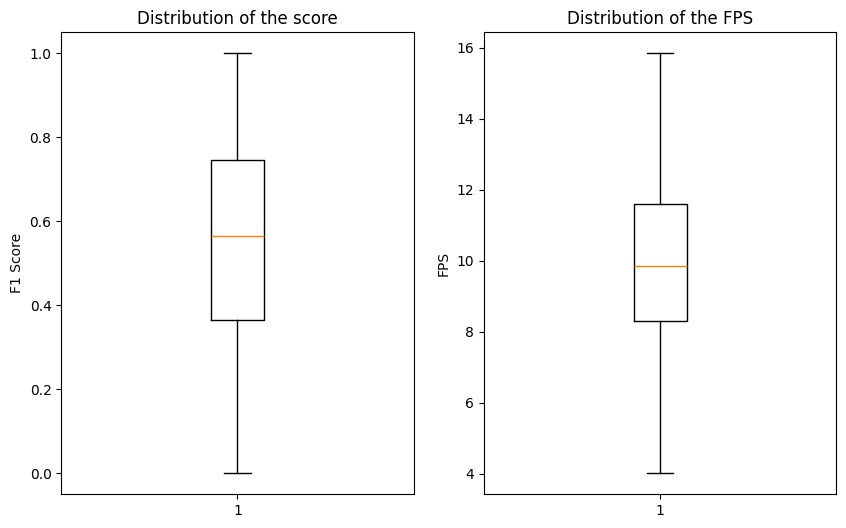

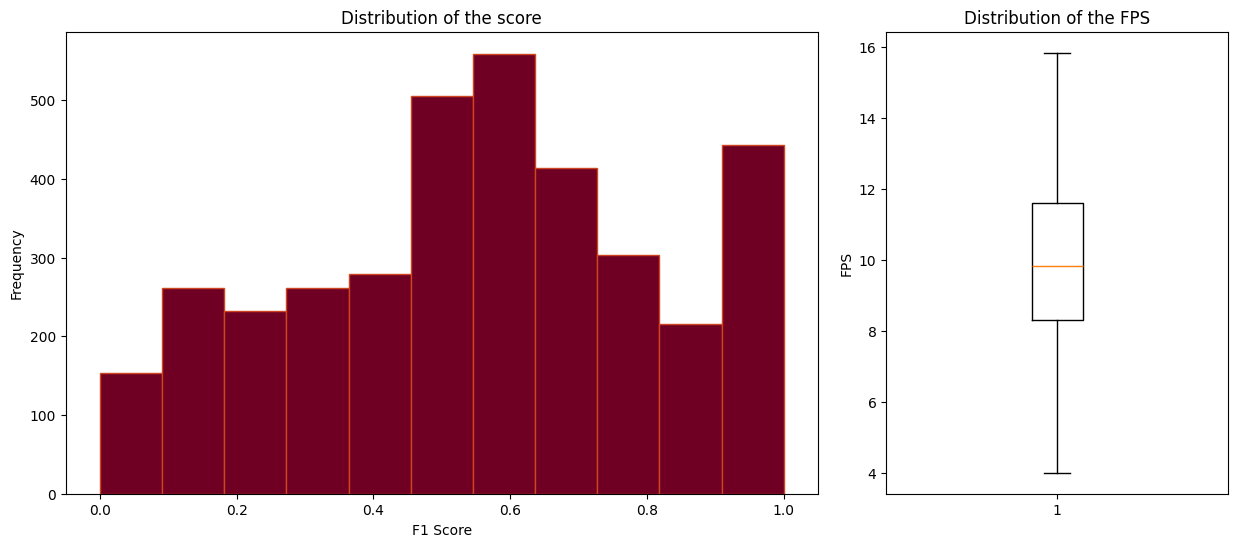

In [2]:
# Transform to FPS
fps = [1/x for x in time]
# plot the distribution of the score
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
ax[0].boxplot(score)
ax[0].set_title('Distribution of the score')
ax[0].set_ylabel('F1 Score')
ax[1].boxplot(fps, showfliers=False)
ax[1].set_ylabel('FPS')
ax[1].set_title('Distribution of the FPS')
plt.show()
# save the figure
import os
import uuid
import os
id = uuid.uuid4()
if not os.path.exists('../results/attempt3/boxplots/{}'.format(id)):
    os.makedirs('../results/attempt3/boxplots/{}'.format(id))
fig.savefig('../results/attempt3/boxplots/{}/boxplot.png'.format(id))
# bucket the score into 5 bins
bins = np.linspace(0.0, 1, 12)
# plot the distribution of the score
fig = plt.figure(figsize=(15, 6))
# Define the grid
from matplotlib.gridspec import GridSpec
gs = GridSpec(1, 3, figure=fig)

ax1 = fig.add_subplot(gs[:-1])
ax1.hist(score, bins=bins, edgecolor=(207/255, 69/255, 32/255), label=['2', '3', '4', '5'], color=(111/255, 0, 36/255))
ax1.set_title('Distribution of the score')
ax1.set_xlabel('F1 Score')
ax1.set_ylabel('Frequency')

ax2 = fig.add_subplot(gs[-1])
ax2.boxplot(fps, showfliers=False)
ax2.set_ylabel('FPS')
ax2.set_title('Distribution of the FPS')

plt.show()
# save the figure
fig.savefig('../results/attempt3/boxplots/{}/histogram.png'.format(id))

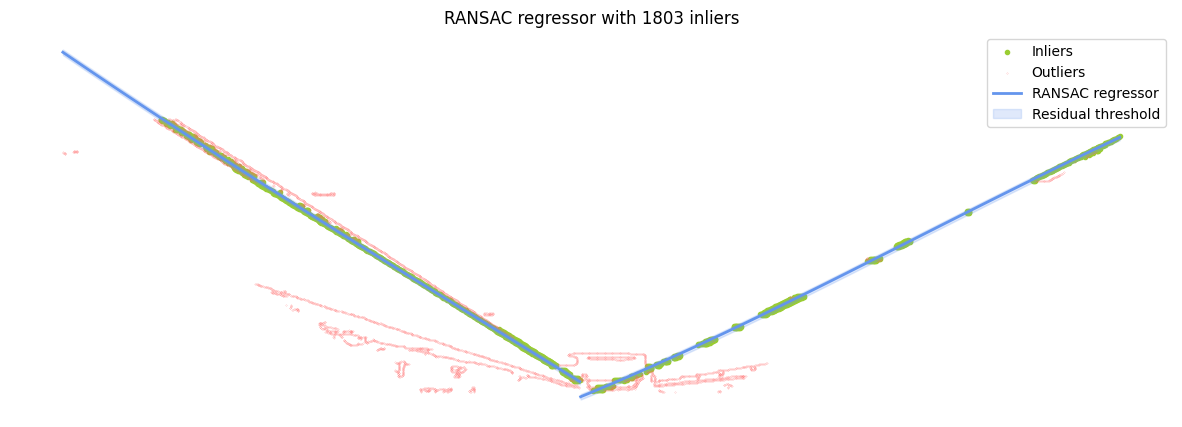

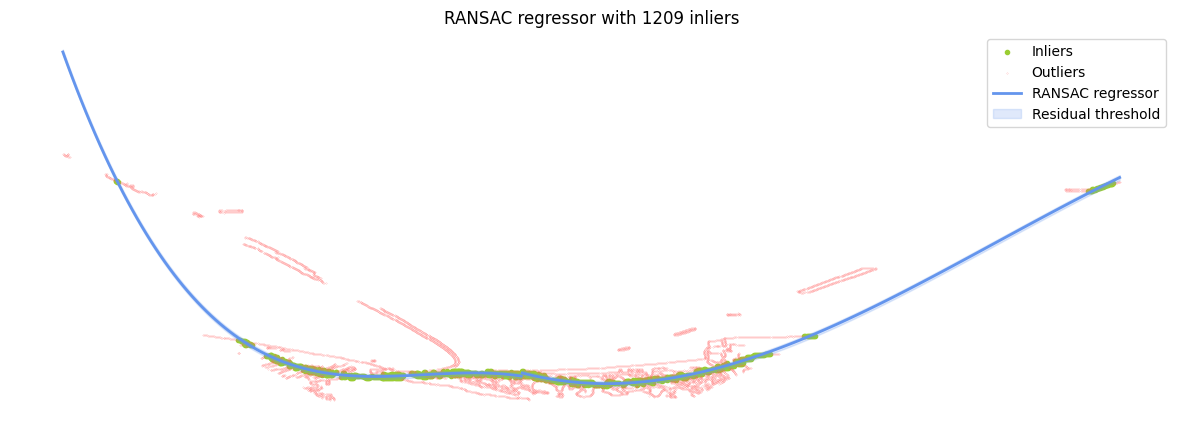

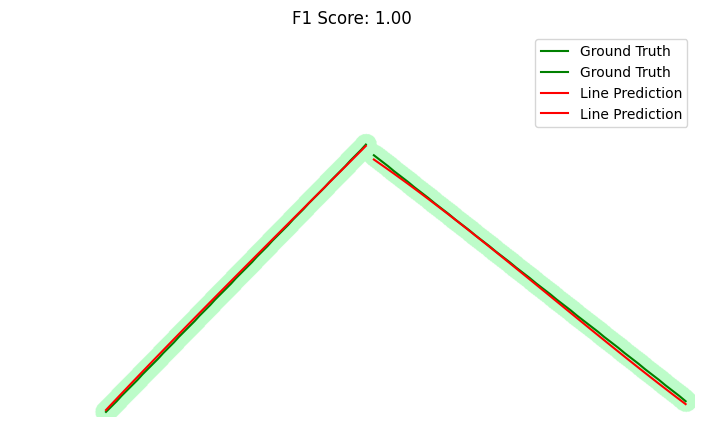

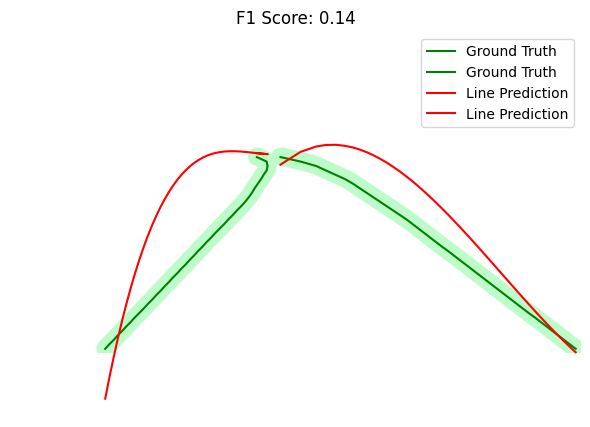

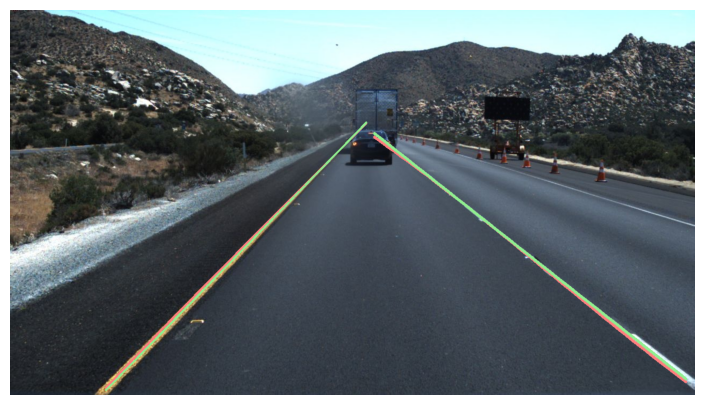

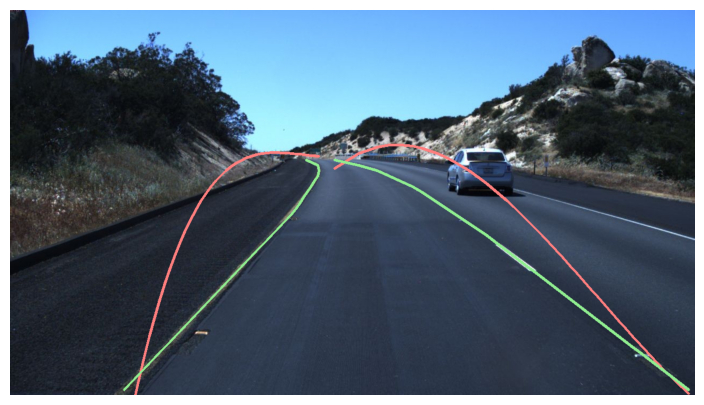

In [3]:
# Plot some of the worst and best results
import QuickFit as qf
# get the index of the best and worst results
import itertools
# shuffle the indices
indices = np.arange(len(score))
np.random.shuffle(indices)
# get the first 10 indices
indices = indices[:500]
# get the best and worst results
random_score = score[indices]
random_path = path[indices]
# get the index of the best and worst results
best = np.argmax(random_score)
worst = np.argmin(random_score)
# get the path of the best and worst results
best_path = random_path[best]
worst_path = random_path[worst]
# replace last folder with 20.jpg
best_path = '/'.join(best_path.split('/')[:-1]) + '/20.jpg'
worst_path = '/'.join(worst_path.split('/')[:-1]) + '/20.jpg'
# Set up quickfit
QF = qf.QuickFit(ransac_max_trials=100, ransac_random_state=42, polynomial_degree=3)
# load the best and worst results
best_image = qf.QuickFit.load_image(best_path)
worst_image = qf.QuickFit.load_image(worst_path)
# load the best and worst labels
clip = '/'.join(best_path.split('/')[-4:-1])+'/20.jpg'
label_path = '../dataset/TUSimple/train_set/label_data_{}.json'.format(best_path.split('/')[-3][:4])
best_label = qf.QuickFit.load_labels(label_path, clip)
clip = '/'.join(worst_path.split('/')[-4:-1])+'/20.jpg'
label_path = '../dataset/TUSimple/train_set/label_data_{}.json'.format(worst_path.split('/')[-3][:4])
worst_label = qf.QuickFit.load_labels(label_path, clip)
# Apply the filter
best_pixels = QF.apply_filter(best_image)
worst_pixels = QF.apply_filter(worst_image)
# Split the pixels into left and right half planes
best_left, best_right = qf.QuickFit.split_pixels(best_pixels, best_image)
worst_left, worst_right = QF.split_pixels(worst_pixels, worst_image)
# Fit a polynomial to the left and right half planes
best_left_fit = QF.fit_line(best_left)
best_right_fit = QF.fit_line(best_right)
worst_left_fit = QF.fit_line(worst_left)
worst_right_fit = QF.fit_line(worst_right)
# Get the line for the left and right half planes
max_x = np.max(best_left[:,0])
min_x = np.min(best_left[:,0])
best_left_PL = qf.QuickFit.predict_line(best_left_fit, (min_x, max_x))
max_x = np.max(best_right[:,0])
min_x = np.min(best_right[:,0])
best_right_PL = qf.QuickFit.predict_line(best_right_fit, (min_x, max_x))
max_x = np.max(worst_left[:,0])
min_x = np.min(worst_left[:,0])
worst_left_PL = qf.QuickFit.predict_line(worst_left_fit, (min_x, max_x))
max_x = np.max(worst_right[:,0])
min_x = np.min(worst_right[:,0])
worst_right_PL = qf.QuickFit.predict_line(worst_right_fit, (min_x, max_x))

# Get the predicted lane lines
best_left_line, best_left_pred_line = qf.QuickFit.get_best_MSE(best_label, best_left_fit)
best_right_line, best_right_pred_line = qf.QuickFit.get_best_MSE(best_label, best_right_fit)
worst_left_line, worst_left_pred_line = qf.QuickFit.get_best_MSE(worst_label, worst_left_fit)
worst_right_line, worst_right_pred_line = qf.QuickFit.get_best_MSE(worst_label, worst_right_fit)

# Render and merge the left and right lines
best_ransac = QF.render_LR_RANSAC(best_left_PL, best_right_PL, best_left_fit, best_right_fit, best_left, best_right)
worst_ransac = QF.render_LR_RANSAC(worst_left_PL, worst_right_PL, worst_left_fit, worst_right_fit, worst_left, worst_right)

# Render the F1 score
best_F1 = QF.render_LR_F1(best_left_pred_line, best_right_pred_line, best_left_line, best_right_line, best_image)
worst_F1 = QF.render_LR_F1(worst_left_pred_line, worst_right_pred_line, worst_left_line, worst_right_line, worst_image)

# Draw the lane lines
best_image = qf.QuickFit.draw_lines(best_image, best_left_line, best_left_pred_line, best_right_line, best_right_pred_line)
worst_image = qf.QuickFit.draw_lines(worst_image, worst_left_line, worst_left_pred_line, worst_right_line, worst_right_pred_line)

# Save the images
import uuid
import os
id = uuid.uuid4()
if not os.path.exists('../results/attempt3/{}'.format(id)):
    os.makedirs('../results/attempt3/{}'.format(id))
best_ransac.savefig('../results/attempt3/{}/best_ransac.png'.format(id), bbox_inches='tight')
worst_ransac.savefig('../results/attempt3/{}/worst_ransac.png'.format(id), bbox_inches='tight')
best_F1.savefig('../results/attempt3/{}/best_F1.png'.format(id), bbox_inches='tight')
worst_F1.savefig('../results/attempt3/{}/worst_F1.png'.format(id), bbox_inches='tight')
best_image.savefig('../results/attempt3/{}/best.png'.format(id), bbox_inches='tight')
worst_image.savefig('../results/attempt3/{}/worst.png'.format(id), bbox_inches='tight')